##Step-by-Step Plan for Multi-Modal Matchmaker App

###Step 1: Understand the Dataset
I'll first inspect the uploaded CSV and show you the structure (features like bios, interests, gender, etc.).

###Step 2: Define Modalities
Text Modality: Bio, interests, preferences

(Optional) Image Modality: If we later include profile images, we can embed them using CLIP

Target: Recommend compatible matches using embedding similarity + RAG-style LLM generation

###Step 3: Build Retrieval-Augmented Pipeline
Use Sentence-BERT to embed bios/interests

Store embeddings with metadata (e.g., gender, location)

On input: take user profile → embed → retrieve similar profiles

Use LLM to generate:

Suggested matches

Conversation starters

Bio rewrite tips



In [2]:
import pandas as pd

# Load the uploaded dataset
file_path = "/content/Online_Dating_Behavior_Dataset.csv"
df = pd.read_csv(file_path)

# Show the first few rows to inspect structure
df.head()


,Gender,PurchasedVIP,Income,Children,Age,Attractiveness,Matches
0,0,1,51777,3,47,5,70
1,1,0,36646,0,42,7,130
2,0,0,53801,1,25,5,0
3,0,0,56105,0,35,8,0
4,0,0,55597,1,36,6,0


In [3]:
!pip install sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 22.6 MB/s eta 0:00:00


In [4]:
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss

# 1. Generate synthetic bios from structured features
def generate_bio(row):
    gender = "man" if row["Gender"] == 0 else "woman"
    vip = "a VIP member" if row["PurchasedVIP"] == 1 else "a regular member"
    bio = (
        f"I'm a {row['Age']}-year-old {gender}, "
        f"{vip}, earning around ${row['Income']:,} annually, "
        f"with {row['Children']} children. "
        f"My friends say I'm a {row['Attractiveness']}/10 in looks. "
        f"I'm looking to connect with someone special!"
    )
    return bio

# Add generated bios to the DataFrame
df["bio"] = df.apply(generate_bio, axis=1)

# 2. Embed bios using Sentence-BERT
model = SentenceTransformer("all-MiniLM-L6-v2")
bio_embeddings = model.encode(df["bio"].tolist(), show_progress_bar=True)

# 3. Create a FAISS index
dimension = bio_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(np.array(bio_embeddings).astype("float32"))

# Store index and corresponding metadata
df["embedding_index"] = range(len(df))

# Preview a few generated bios
df[["bio"]].head()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

,bio
0,"I'm a 47-year-old man, a VIP member, earning a..."
1,"I'm a 42-year-old woman, a regular member, ear..."
2,"I'm a 25-year-old man, a regular member, earni..."
3,"I'm a 35-year-old man, a regular member, earni..."
4,"I'm a 36-year-old man, a regular member, earni..."


In [5]:
model = SentenceTransformer("all-MiniLM-L6-v2")
bio_embeddings = model.encode(df["bio"].tolist(), show_progress_bar=True)

# 3. Create FAISS index
dimension = bio_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(np.array(bio_embeddings).astype("float32"))

# Optional: Save index and bios for reuse
faiss.write_index(faiss_index, "matchmaker_faiss.index")
df.to_csv("profiles_with_bios.csv", index=False)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [9]:
df_bios = pd.read_csv("/content/profiles_with_bios.csv")
df_bios.head(-5)

,Gender,PurchasedVIP,Income,Children,Age,Attractiveness,Matches,bio,embedding_index
0,0,1,51777,3,47,5,70,"I'm a 47-year-old man, a VIP member, earning a...",0
1,1,0,36646,0,42,7,130,"I'm a 42-year-old woman, a regular member, ear...",1
2,0,0,53801,1,25,5,0,"I'm a 25-year-old man, a regular member, earni...",2
3,0,0,56105,0,35,8,0,"I'm a 35-year-old man, a regular member, earni...",3
4,0,0,55597,1,36,6,0,"I'm a 36-year-old man, a regular member, earni...",4
...,...,...,...,...,...,...,...,...,...
990,1,1,50436,2,42,3,90,"I'm a 42-year-old woman, a VIP member, earning...",990
991,1,0,66950,1,37,6,120,"I'm a 37-year-old woman, a regular member, ear...",991
992,1,0,43773,0,34,4,100,"I'm a 34-year-old woman, a regular member, ear...",992
993,1,0,51946,2,25,7,130,"I'm a 25-year-old woman, a regular member, ear...",993


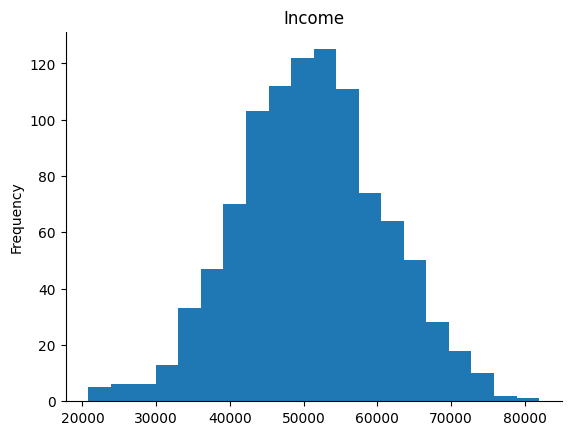

In [10]:
# @title Income

from matplotlib import pyplot as plt
df_bios['Income'].plot(kind='hist', bins=20, title='Income')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Function to Recommend Matches

In [6]:
def recommend_matches(user_bio, top_k=5):
    # Embed the input bio
    query_embedding = model.encode([user_bio]).astype("float32")

    # Search top-k similar profiles
    distances, indices = faiss_index.search(query_embedding, top_k)

    print("\n Top Match Recommendations:")
    for i, idx in enumerate(indices[0]):
        match_bio = df.iloc[idx]["bio"]
        print(f"\nMatch #{i+1}:")
        print(match_bio)


## Examples

In [7]:
# Example user bio
user_input_bio = "I'm a 34-year-old woman, love hiking and family life. Earning well and looking for a genuine connection."

# Recommend top 5 matches
recommend_matches(user_input_bio)



 Top Match Recommendations:

Match #1:
I'm a 34-year-old woman, a VIP member, earning around $50,320 annually, with 0 children. My friends say I'm a 10/10 in looks. I'm looking to connect with someone special!

Match #2:
I'm a 34-year-old man, a VIP member, earning around $53,230 annually, with 0 children. My friends say I'm a 8/10 in looks. I'm looking to connect with someone special!

Match #3:
I'm a 34-year-old woman, a VIP member, earning around $40,316 annually, with 1 children. My friends say I'm a 8/10 in looks. I'm looking to connect with someone special!

Match #4:
I'm a 31-year-old man, a regular member, earning around $52,246 annually, with 0 children. My friends say I'm a 4/10 in looks. I'm looking to connect with someone special!

Match #5:
I'm a 34-year-old woman, a VIP member, earning around $51,255 annually, with 1 children. My friends say I'm a 10/10 in looks. I'm looking to connect with someone special!


## Next Step: Generate images from Bio and create a multi-modal RAG

           [User Bio Input]
                  │
         ┌────────▼────────┐
         │ Text-to-Image AI│ (e.g., SDXL)
         └────────┬────────┘
                  │
     [Generated Profile Image]
                  │
         ┌────────▼────────┐
         │  Image Encoder  │  ◄─── CLIP / BLIP
         └────────┬────────┘
                  │
     [Image Embedding Vector]
                  │
    [Text Embedding from Bio]
                  │
     ┌────────────▼────────────┐
     │      FAISS Multi-Index   │  ← (concat image+text embeddings)
     └────────────┬────────────┘
                  │
      [Retrieve similar profiles]
                  │
       [LLM: generate reply, match suggestions]


### Tools

| Task                     | Tool/Model                    |
| ------------------------ | ----------------------------- |
| Text-to-Image Generation | **Stable Diffusion (SDXL)**   |
| Image Embedding          | **CLIP (ViT-B/32)**           |
| Text Embedding           | **Sentence-BERT**             |
| Multi-modal RAG          | **FAISS**                     |
| Generation (optional)    | **GPT-4 / LLaMA / OCI GenAI** |


In [12]:
# import necessary libraries due to kernel reset
import pandas as pd
import os
from PIL import Image, ImageDraw, ImageFont


# Create directory for images
image_dir = "/content/generated_profile_images"
os.makedirs(image_dir, exist_ok=True)

# Generate placeholder images with bio text
def create_profile_image(bio_text, filename):
    img = Image.new('RGB', (512, 512), color='white')
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("arial.ttf", 18)
    except:
        font = ImageFont.load_default()

    words = bio_text.split()
    lines, line = [], ""
    for word in words:
        if len(line + word) < 60:
            line += word + " "
        else:
            lines.append(line.strip())
            line = word + " "
    lines.append(line.strip())

    y = 20
    for line in lines:
        draw.text((20, y), line, fill='black', font=font)
        y += 25

    img.save(filename)

# Create images for first 5 bios
image_paths = []
for i, bio in enumerate(df["bio"]):
    filename = os.path.join(image_dir, f"profile_{i+1}.jpg")
    create_profile_image(bio, filename)
    image_paths.append(filename)

image_paths

['/content/generated_profile_images/profile_1.jpg',
 '/content/generated_profile_images/profile_2.jpg',
 '/content/generated_profile_images/profile_3.jpg',
 '/content/generated_profile_images/profile_4.jpg',
 '/content/generated_profile_images/profile_5.jpg',
 '/content/generated_profile_images/profile_6.jpg',
 '/content/generated_profile_images/profile_7.jpg',
 '/content/generated_profile_images/profile_8.jpg',
 '/content/generated_profile_images/profile_9.jpg',
 '/content/generated_profile_images/profile_10.jpg',
 '/content/generated_profile_images/profile_11.jpg',
 '/content/generated_profile_images/profile_12.jpg',
 '/content/generated_profile_images/profile_13.jpg',
 '/content/generated_profile_images/profile_14.jpg',
 '/content/generated_profile_images/profile_15.jpg',
 '/content/generated_profile_images/profile_16.jpg',
 '/content/generated_profile_images/profile_17.jpg',
 '/content/generated_profile_images/profile_18.jpg',
 '/content/generated_profile_images/profile_19.jpg',
 '

In [14]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qr7t3yuq
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qr7t3yuq
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=3352e4e374a2512d04dbb34600d261979323fb7d3ed6df859e48303c6dbb927d
  Stored in directory: /tmp/pip-ephem-wheel-cache-qlftkwqk/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


In [17]:
import torch
import clip
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
import numpy as np
import faiss

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Preprocessing for CLIP
transform = Compose([
    Resize(224, interpolation=Image.BICUBIC),
    CenterCrop(224),
    ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073),
              (0.26862954, 0.26130258, 0.27577711))
])

# Encode text bios using CLIP's text encoder
bios = df["bio"].tolist()
text_tokens = clip.tokenize(bios).to(device)
with torch.no_grad():
    text_embeddings = clip_model.encode_text(text_tokens).cpu().numpy()

# Encode images using CLIP's image encoder
image_embeddings = []
for path in image_paths:
    image = preprocess(Image.open(path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embedding = clip_model.encode_image(image).cpu().numpy()[0]
    image_embeddings.append(image_embedding)

image_embeddings = np.array(image_embeddings)

# Combine text and image embeddings into one vector (e.g., by concatenation)
combined_embeddings = np.concatenate([text_embeddings, image_embeddings], axis=1)

# Create FAISS index
dimension = combined_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(combined_embeddings)

# Save the FAISS index for later use
faiss.write_index(faiss_index, "/content/multimodal_matchmaker.index")

# Output sample combined embedding shape
combined_embeddings.shape

(1000, 1024)

### Generate recommendations

In [20]:
import faiss
import torch
import clip
import numpy as np
from PIL import Image
from sentence_transformers import SentenceTransformer
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import pandas as pd

# Load your profiles CSV with bios
df = pd.read_csv("profiles_with_bios.csv")  # must match the indexed data

# Load FAISS index
index = faiss.read_index("/content/multimodal_matchmaker.index")

# Load models
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
# text_model = SentenceTransformer("all-MiniLM-L6-v2") # Remove SentenceTransformer

# Function to recommend matches
def recommend_matches(user_bio, user_image_path, top_k=5):
    # Embed user bio using CLIP text encoder
    text_tokens = clip.tokenize([user_bio]).to(device)
    with torch.no_grad():
        text_emb = clip_model.encode_text(text_tokens).cpu().numpy()[0]

    # Embed user image
    image = clip_preprocess(Image.open(user_image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_emb = clip_model.encode_image(image).cpu().numpy()[0]

    # Concatenate embeddings
    query_vector = np.concatenate([text_emb, image_emb]).astype("float32")

    # Search FAISS index
    D, I = index.search(np.array([query_vector]), top_k)

    print("\n Top Matches:")
    for rank, idx in enumerate(I[0]):
        print(f"\nMatch #{rank+1}:")
        print(df.iloc[idx]["bio"])

In [21]:
recommend_matches(
    user_bio=df.iloc[0]["bio"],
    user_image_path="/content/generated_profile_images/profile_1.jpg"
)


🔍 Top Matches:

Match #1:
I'm a 47-year-old man, a VIP member, earning around $51,777 annually, with 3 children. My friends say I'm a 5/10 in looks. I'm looking to connect with someone special!

Match #2:
I'm a 47-year-old man, a VIP member, earning around $53,772 annually, with 0 children. My friends say I'm a 4/10 in looks. I'm looking to connect with someone special!

Match #3:
I'm a 47-year-old man, a VIP member, earning around $47,231 annually, with 0 children. My friends say I'm a 5/10 in looks. I'm looking to connect with someone special!

Match #4:
I'm a 47-year-old man, a VIP member, earning around $55,387 annually, with 1 children. My friends say I'm a 6/10 in looks. I'm looking to connect with someone special!

Match #5:
I'm a 42-year-old man, a VIP member, earning around $61,618 annually, with 1 children. My friends say I'm a 7/10 in looks. I'm looking to connect with someone special!


## Running App

In [23]:
import gradio as gr
import pandas as pd
import numpy as np
import faiss
import torch
import clip
from PIL import Image
from sentence_transformers import SentenceTransformer
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

# Load data and models
df = pd.read_csv("/content/profiles_with_bios.csv")
index = faiss.read_index("/content/multimodal_matchmaker.index")
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
text_model = SentenceTransformer("all-MiniLM-L6-v2")

def recommend_matches(user_bio, user_image, top_k=3):
    # Embed text
    text_emb = text_model.encode([user_bio])[0]

    # Embed image
    image = clip_preprocess(user_image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_emb = clip_model.encode_image(image).cpu().numpy()[0]

    # Combine
    query_vector = np.concatenate([text_emb, image_emb]).astype("float32")

    # Search
    D, I = index.search(np.array([query_vector]), top_k)

    # Return top bios
    results = df.iloc[I[0]]["bio"].tolist()
    return "\n\n---\n\n".join([f"Match #{i+1}:\n{bio}" for i, bio in enumerate(results)])

# Gradio UI
iface = gr.Interface(
    fn=recommend_matches,
    inputs=[
        gr.Textbox(label="Your Bio", placeholder="Tell us about yourself..."),
        gr.Image(type="pil", label="Upload Profile Image")
    ],
    outputs=gr.Textbox(label="Top Match Recommendations"),
    title="Multi-Modal Matchmaker ",
    description="Enter your bio and upload a photo to find your best matches!"
)

if __name__ == "__main__":
    iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f6e7e79505a68db198.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
